# Milestone 1

## Preprocess

In [1]:
import nltk
#imports
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import stanza
import nltk

In [2]:
nltk.download('stopwords')
german_stop_words = nltk.corpus.stopwords.words('german')
stanza.download('de')
nlp=stanza.Pipeline(processors="tokenize,mwt,lemma", lang="de",use_gpu=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-09 21:16:00 INFO: Downloading default packages for language: de (German) ...
2022-11-09 21:16:01 INFO: File exists: C:\Users\marti\stanza_resources\de\default.zip
2022-11-09 21:16:04 INFO: Finished downloading models and saved to C:\Users\marti\stanza_resources.
2022-11-09 21:16:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-09 21:16:04 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| lemma     | gsd     |

2022-11-09 21:16:04 INFO: Use device: gpu
2022-11-09 21:16:04 INFO: Loading: tokenize
2022-11-09 21:16:06 INFO: Loading: mwt
2022-11-09 21:16:06 INFO: Loading: lemma
2022-11-09 21:16:06 INFO: Done loading processors!


In [3]:
# changed to relative path
WD='../'
data_path=WD+'data/input/'

separate to labels and features

In [4]:
train_df=pd.read_csv(data_path+'train_data.csv')
valid_df=pd.read_csv(data_path+'valid_data.csv')

In [5]:
def tokenize(input: str):
    doc=nlp(input)
    return[word.lemma  for sent in doc.sentences for word in sent.words if word.lemma not in german_stop_words]

In [6]:
def preprocess_features(df:pd.DataFrame,type_of_data:str,vocab=None):
    vectorizer=CountVectorizer(tokenizer=tokenize,vocabulary=vocab)
    features = df.iloc[:,[0,1]].copy()
    vectors=vectorizer.fit_transform(features.Text).toarray()
    transformed_features=pd.DataFrame(vectors,columns=vectorizer.get_feature_names_out())
    #features[vectorizer.get_feature_names_out()]=vectors
    features=features.join(transformed_features)
    features.to_csv((data_path+type_of_data+'_features.csv'), index=False)
    return  features.columns[2:].tolist()


In [7]:
def preprocess_labels(df:pd.DataFrame,type_of_data:str,binary_clases=None,):
    labels =  df.iloc[:,[0,2]].copy()
    labels.Labels=labels.Labels.apply(ast.literal_eval)
    mlb=MultiLabelBinarizer(classes=binary_clases)
    labels_transformed=mlb.fit_transform(labels['Labels'])
    labels[mlb.classes_]=labels_transformed
    labels.to_csv((data_path+type_of_data+'_labels.csv'), index=False)
    return mlb.classes_

In [8]:
def preprocess_df(df: pd.DataFrame,type_of_data:str,vocab=None,classes=None):
    vocab=preprocess_features(df,type_of_data,vocab)
    classes=preprocess_labels(df,type_of_data,classes)
    return  vocab,classes


In [10]:
%%time
vocab,classes=preprocess_df(train_df,'train')
v,c=preprocess_df(valid_df,'valid',vocab,classes)

C:\Users\marti\PycharmProjects\nlp\project-enterbrise\venv\lib\site-packages\scikit_learn-1.1.2-py3.10-win-amd64.egg\sklearn\feature_extraction\text.py:1330: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


CPU times: total: 1min 59s
Wall time: 3min 6s


C:\Users\marti\PycharmProjects\nlp\project-enterbrise\venv\lib\site-packages\scikit_learn-1.1.2-py3.10-win-amd64.egg\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['AnteilBaumbepflanzung'] will be ignored
  warnings.warn(


## Training and Evaluation


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [12]:
df_features = pd.read_csv(data_path+'train_features.csv')
df_labels = pd.read_csv(data_path+'train_labels.csv')
valid_features = pd.read_csv(data_path+'valid_features.csv')
valid_labels = pd.read_csv(data_path+'valid_labels.csv')

In [13]:
df_labels

,ID,Labels,AbschlussDachMaxBezugGebaeude,AbschlussDachMaxBezugGelaende,AnFluchtlinie,AnOeffentlichenVerkehrsflaechen,AnlageZumEinstellenVorhanden,AnordnungGaertnerischeAusgestaltung,AnordnungGaertnerischeAusgestaltungProzentual,AnteilDachbegruenung,...,VerkehrsflaecheID,VolumenUndUmbaubarerRaum,VonBebauungFreizuhalten,VorbautenBeschraenkung,VorbautenVerbot,VorkehrungBepflanzung,VorstehendeBauelementeAusladungMax,Widmung,WidmungInMehrerenEbenen,ZulaessigeGeschossanzahlEinkaufszentrum
0,8025_0_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8025_0_1,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8025_1_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8025_2_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8025_3_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,7737_12_1,"['BegruenungDach', 'Dachart']",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5364,7737_12_2,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5365,7737_12_3,['AufbautenZulaessig'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5366,7737_13_0,"['AnordnungGaertnerischeAusgestaltung', 'Ausna...",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
valid_labels

,ID,Labels,AbschlussDachMaxBezugGebaeude,AbschlussDachMaxBezugGelaende,AnFluchtlinie,AnOeffentlichenVerkehrsflaechen,AnlageZumEinstellenVorhanden,AnordnungGaertnerischeAusgestaltung,AnordnungGaertnerischeAusgestaltungProzentual,AnteilDachbegruenung,...,VerkehrsflaecheID,VolumenUndUmbaubarerRaum,VonBebauungFreizuhalten,VorbautenBeschraenkung,VorbautenVerbot,VorkehrungBepflanzung,VorstehendeBauelementeAusladungMax,Widmung,WidmungInMehrerenEbenen,ZulaessigeGeschossanzahlEinkaufszentrum
0,8118_0_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8118_0_1,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8118_1_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8118_2_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8118_3_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,7300k_4_0,"['GebaeudeHoeheMaxAbsolut', 'Planzeichen', 'Wi...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
797,7300k_4_1,['AbschlussDachMaxBezugGelaende'],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,7300k_5_0,"['EinfriedungZulaessig', 'Planzeichen', 'Widmu...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
799,7300k_6_0,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y_train=df_labels.iloc[:, 2:].copy()
x_train=df_features.iloc[:, 2:].copy()

In [21]:
y_test=valid_labels.iloc[:, 2:].copy()
x_test=valid_features.iloc[:, 2:].copy()

In [25]:
%%time
# Fitting Random Forest Classification to the Training set
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
#classifier_deep = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
classifier_rf.fit(x_train, y_train)
#classifier_deep.fit(x_train, y_train)

CPU times: total: 7.48 s
Wall time: 10.7 s


RandomForestClassifier(criterion='entropy', random_state=42)

In [26]:
# Predicting the Test set results
y_pred_rf = classifier_rf.predict(x_test)
#y_pred_deep = classifier_deep.predict(x_test)

C:\Users\marti\PycharmProjects\nlp\project-enterbrise\venv\lib\site-packages\scikit_learn-1.1.2-py3.10-win-amd64.egg\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- !ng
- -balz
- -fröhlichsandner
- -geschäftsviertel
- -lamm
- ...
Feature names seen at fit time, yet now missing:
- '
- 'bestimmen
- *
- +100,0
- +130-180
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 1372 features, but RandomForestClassifier is expecting 4175 features as input.

In [9]:
report_rf=metrics.classification_report(
    y_test,
    y_pred_rf,
    output_dict=True,#,target_names=['class A', 'class B', 'class C']
    zero_division=0
)

report_deep=metrics.classification_report(
    y_test,
    y_pred_deep,
    output_dict=True,#,target_names=['class A', 'class B', 'class C']
    zero_division=0
)

In [10]:
macros=['micro avg','macro avg','weighted avg','samples avg']
scores=['precision','recall','f1-score']

In [11]:
df = pd.DataFrame(columns=['model','measure','value'])

In [12]:
for macro in macros:
    for score in scores:
        df.loc[len(df)] = ['rf',macro+'-'+score,report_rf[macro][score]]
        df.loc[len(df)] = ['deep',macro+'-'+score,report_deep[macro][score]]

df.head()

,model,measure,value
0,rf,micro avg-precision,0.960961
1,deep,micro avg-precision,0.917550
2,rf,micro avg-recall,0.721533
3,deep,micro avg-recall,0.878241
4,rf,micro avg-f1-score,0.824211


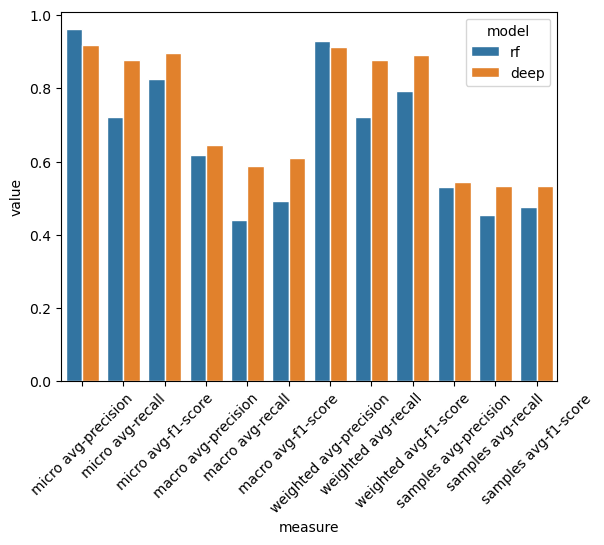

In [15]:

sns.barplot(x = 'measure', y = 'value', hue = 'model', data = df,
            palette = 'tab10', edgecolor = 'w')
# tips.groupby(['day','model']).mean()
# sns.set(font_scale = 5)
plt.xticks(rotation=45)
plt.savefig("model_comparison.jpg",dpi=300 )
plt.show()

In [16]:
# print(metrics.classification_report(y_pred, y_test))

In [17]:
# cm = accuracy_score(y_test, y_pred)
# cm

In [18]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred)


In [19]:
labels = ["".join("c" + str(i)) for i in range(0, y_pred.shape[1])]

In [20]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

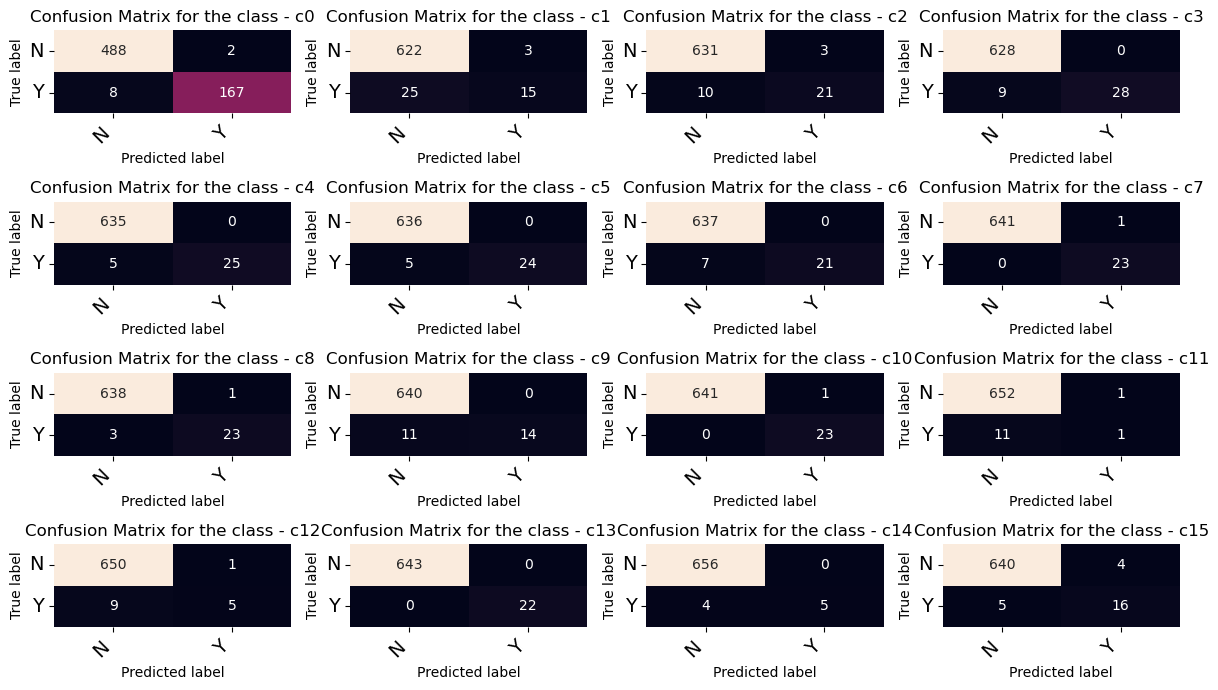

In [21]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

# metrics for multi-label classification

We have unbalanced classes, so accuracy is not a good metric. Better precision,recall, f1-score etc.
For each class, we can compute the usual metrics for binary classification, and the confusion matrix.

Aggregate metrics like macro, micro, weighted and sampled avg give us a high-level view of how our model is performing.

## macro average
This is simply the average of a metric — precision, recall or f1-score — over all classes.

## Micro average
The micro-average of a metric is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average

## Weighted average
This is simply the average of the metric values for individual classes weighted by the support of that class. The support is how many times a class appeared in y_test.

## Samples average
Here, we compute metrics for each sample and then average them.